In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image

# Directory paths
stone_dir = "/kaggle/input/kidney-ultrasound-images-stone-and-no-stone/my dataset final 512x512(implemented)/stone"
no_stone_dir = "/kaggle/input/kidney-ultrasound-images-stone-and-no-stone/my dataset final 512x512(implemented)/Normal"

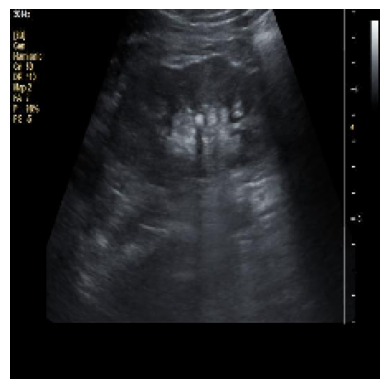

In [4]:
import matplotlib.pyplot as plt
if not os.path.exists(stone_dir):
    print(f"Directory not found: {stone_dir}")
else:
    # List files in the stone directory
    stone_files = os.listdir(stone_dir)
    if len(stone_files) > 5:
        image_path = os.path.join(stone_dir, stone_files[5])  # Take the sixth image in the directory
        
        # Load the image and convert it to a format suitable for display
        img = image.load_img(image_path, target_size=(224, 224))
        img_array = image.img_to_array(img) / 255.0  # Normalize the image (0 to 1 range)

        # Display the image
        plt.imshow(img_array)
        plt.axis('off')  # Turn off axis
        plt.show()
    else:
        print("Not enough images in the stone directory.")



In [5]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Define image size for consistency
image_size = (224, 224)

# Function to load images and display them with their labels
def load_images_from_directory(directory, label):
    images = []
    labels = []
    
    # List files in the directory
    filenames = os.listdir(directory)
    if not filenames:
        print(f"Warning: No images found in {directory}")
    
    for filename in filenames:
        img_path = os.path.join(directory, filename)
        
        # Only process jpg or png images
        if img_path.endswith(".JPG") or img_path.endswith(".png"):
            try:
                # Load and preprocess the image
                img = image.load_img(img_path, target_size=image_size)
                img_array = image.img_to_array(img) / 255.0  # Normalize image values to [0, 1]
                
                # Append to images and labels lists
                images.append(img_array)
                labels.append(label)
                
                # Display the image and its label
                #plt.imshow(img_array)
                #plt.title(f"Label: {label}")  # Display the label as the title
               # plt.axis('off')  # Hide axes for a cleaner view
               # plt.show()
                
                #print(f"Image: {filename}, Label: {label}")
            except Exception as e:
                print(f"Error loading image {filename}: {e}")

    return images, labels

In [6]:
stone_images, stone_labels = load_images_from_directory(stone_dir, 1)  # Label 1 for stone
no_stone_images, no_stone_labels = load_images_from_directory(no_stone_dir, 0)  # La

In [7]:
images = np.concatenate((stone_images, no_stone_images), axis=0)
labels = np.concatenate((stone_labels, no_stone_labels), axis=0)

In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models, optimizers
X_train = resnet_preprocess(X_train)
X_val = resnet_preprocess(X_val)
X_test = resnet_preprocess(X_test)

# ===============================


In [11]:
from tensorflow.keras.models import Model

inputs = tf.keras.Input(shape=(224, 224, 3))

# --- ResNet50 as frozen feature extractor ---
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
resnet_base.trainable = False
x = resnet_base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)  # (2048,)

# --- EfficientNet-style classifier head ---
x = layers.Dense(512, activation='swish')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation='swish')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='swish')(x)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
# =========================


In [12]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,801,153 (94.61 MB)

 Trainable params: 1,213,441 (4.63 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# ===============================
# Train Model
# ===============================
checkpoint = ModelCheckpoint(
    "best_model_resnet_effnet.h5",
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=16,
    callbacks=[checkpoint]
)

# ===============================
# Evaluate Model
# ===============================
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# ===============================
# Plot Accuracy Curves
# ===============================
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('ResNet50 Feature Extractor + EfficientNet-style Classifier')
plt.show()

Epoch 1/25
471/471 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5285 - loss: 0.6988
Epoch 1: val_loss improved from inf to 0.66975, saving model to best_model_resnet_effnet.h5
471/471 ━━━━━━━━━━━━━━━━━━━━ 892s 2s/step - accuracy: 0.5285 - loss: 0.6988 - val_accuracy: 0.5255 - val_loss: 0.6697
Epoch 2/25
471/471 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6071 - loss: 0.6530
Epoch 2: val_loss improved from 0.66975 to 0.51400, saving model to best_model_resnet_effnet.h5
471/471 ━━━━━━━━━━━━━━━━━━━━ 840s 2s/step - accuracy: 0.6072 - loss: 0.6529 - val_accuracy: 0.8556 - val_loss: 0.5140
Epoch 3/25
471/471 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7498 - loss: 0.5091
Epoch 3: val_loss improved from 0.51400 to 0.36892, saving model to best_model_resnet_effnet.h5
471/471 ━━━━━━━━━━━━━━━━━━━━ 811s 2s/step - accuracy: 0.7498 - loss: 0.5091 - val_accuracy: 0.8970 - val_loss: 0.3689
Epoch 4/25
381/471 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - accuracy: 0.8272 - loss: 0.3849

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Step 1: Make predictions on the test data
y_pred = model.predict(X_test)

# Step 2: Threshold predictions to get binary outputs (0 or 1)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Step 3: Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Step 4: Plot the confusion matrix using Seaborn for better visualization
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stone', 'Stone'], yticklabels=['No Stone', 'Stone'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Optional: Print confusion matrix values for reference
print(f"Confusion Matrix:\n{cm}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Step 1: Make predictions on the test data
y_pred = model.predict(X_test)

# Step 2: Threshold predictions to get binary outputs (0 or 1)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Step 3: Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Step 4: Plot the confusion matrix using Seaborn for better visualization
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stone', 'Stone'], yticklabels=['No Stone', 'Stone'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Optional: Print confusion matrix values for reference
print(f"Confusion Matrix:\n{cm}")